In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats as scipy_stats

import scipy.linalg as scipy_linalg

import scipy.optimize as optimize

import scipy.integrate as integrate

import scipy.special as special

# Spearman's Rho Correlation

<h3>

There are lots of situations where we want to find if two parameters are correlated.  But we often have messy data - it may have lots of outliers or large variance, or may just not look like a linear correlation, even if there is a trend.

To make our analysis less sensitive these problems, what we can do is not use the actual values of the two parameters we are comparing.  Instead, we rank each set of parameters from lowest to highest, and then look for a correlation between the rankings.  

This is called Spearman's rho correlation or Spearman's rank correlation.  

Using the actual values to find the linear correlation, rather than the ranking, is sometimes called Pearson's correltation.  (You really just care about the correlation coefficient, not the intercept.)

We are going to work through a real example of using this.  Tariqi & Naughton (2021) looked for a correlation between nitrate contamination in ground water and thyroid cancer rates in California.  These data are rather noisy.  But by ranking thyroid cancer rates in each county in California and comparing to different measure of nitrate contamination, they were able to show a correlation.

Traiqi, A.Q., Naughton, C.C., 2021, Environ Eng Sci, 38(5), 377–388, https://pmc.ncbi.nlm.nih.gov/articles/PMC8165459/

We are going to go though and try to reprocude these results.

First, let do a dummy example using fake data.
    
</h3>

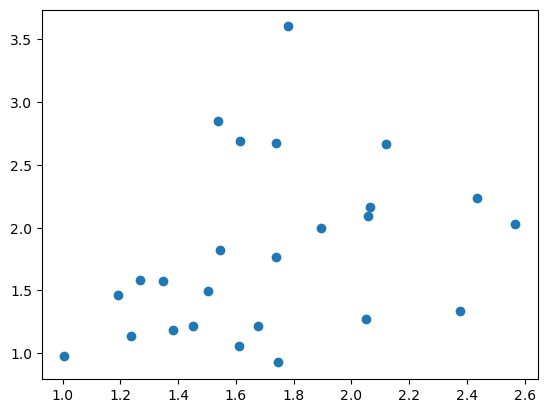

In [61]:
# First, make a coupld of data sets.

n=25

np.random.seed(101)

x = np.arange(n)/(n-1)

data1 = (np.log(x*2+1)+1) + np.random.normal(loc=0,scale=.25,size=n)

data2 = (0.5*x**2+x+1) + np.random.normal(loc=0,scale=.55,size=n)

plt.plot(data1,data2,'o')
plt.show()


<h3>

That's some pretty ugly data.  Let's see what king of correlation we get:
    
</h3>


PearsonRResult(statistic=0.33904346015697767, pvalue=0.09732680101185524)
(array([0.58251229, 0.80148501]), array([[ 0.25759946, -0.44251498],
       [-0.44251498,  0.80017049]]))


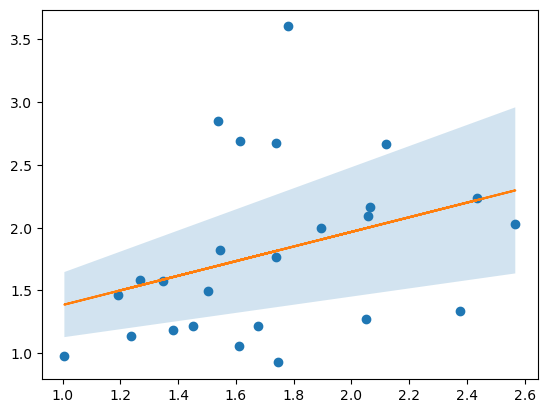

Pearson statistic is  0.33904346015697767
Pearson p-value is  0.09732680101185524


In [62]:
pearson_test = scipy_stats.pearsonr(data1,data2)

print(pearson_test)

linear_test = np.polyfit(data1,data2,1,cov='unscaled')
print(linear_test)

m = linear_test[0][0]
b = linear_test[0][1]

xx = np.sort(data1)


plt.plot(data1,data2,'o')
plt.plot(data1,m*data1+b)
#plt.plot(data1,(m-linear_test[1][0,0])*data1+b)
plt.fill_between(xx,(m-linear_test[1][0,0])*xx+b,(m+linear_test[1][0,0])*xx+b,alpha=0.2)
plt.show()

print('Pearson statistic is ',pearson_test.statistic)
print('Pearson p-value is ',pearson_test.pvalue)



<h3>

So not a great result.  There is some correlation, but it's consistent with zero (p = 0.1).

Let's try Speaman's rho correlation on the same data:
    
</h3>

SignificanceResult(statistic=0.4469230769230769, pvalue=0.025103582497618553)
(array([0.44692308, 6.63692308]), array([[ 0.00076923, -0.00923077],
       [-0.00923077,  0.15076923]]))


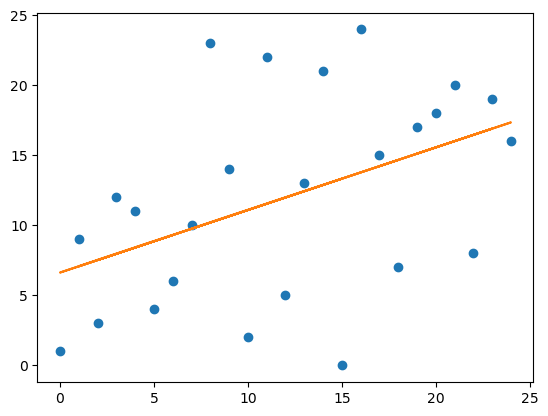

Speaman statistic is  0.4469230769230769
Spearman p-value is  0.025103582497618553


In [196]:
spearman_test = scipy_stats.spearmanr(data1,data2)

print(spearman_test)

#rank1 = np.argsort(data1)
#rank2 = np.argsort(data2)

index = np.arange(data1.size)
rank = np.argsort(data1)
rate = np.zeros(data1.size)
rate[rank] = index
rank1 = np.copy(rate)

index = np.arange(data2.size)
rank = np.argsort(data2)
rate = np.zeros(data2.size)
rate[rank] = index
rank2 = np.copy(rate)



rank_test = np.polyfit(rank1,rank2,1,cov='unscaled')
print(rank_test)

m = rank_test[0][0]
b = rank_test[0][1]

xx = np.sort(rank1)


plt.plot(rank1,rank2,'o')
plt.plot(rank1,m*rank1+b)
#plt.plot(rank1,(m-rank_test[1][0,0])*rank1+b)
plt.fill_between(xx,(m-rank_test[1][0,0])*xx+b,(m+rank_test[1][0,0])*xx+b,alpha=0.2)
plt.show()

print('Speaman statistic is ',spearman_test.statistic)
print('Spearman p-value is ',spearman_test.pvalue)


<h3>

This looks a bit cleaner.  There's still some outliers, but things look closer to a line.  The p-value here is more significant (p=0.025 < 0.05).
    
</h3>

# Real Data

<h3>

Now let's take a look at some real data.  The number of cancer cases per 100,000 population by county can be found at the California Cancer Registry https://cancer-rates.info/ca/

It will give the population, number of (thyroid) cancer cases, and age-adjusted rate (along with 95% confidence interval) for eahc county or region.  Some counties are combined to get enough data, so we end up with 47 different region.  Note that the paper uses cancer rates from a single year, 2014, so they have to deal with low numbers of cases in some region.  I've taken the rates for 2013-2017 and put them in a spreasheet to make things a little easier.

The nitrate comtamination is a lot hrader to measure, and it's the main work of the paper.  They take well measurement of nitrate levels from the California Water Baords (GAMA) website https://gamagroundwater.waterboards.ca.gov/gama/gamamap/public/  

Measurements over time are averaged for each well, and geospatial analysis was used to group well locations with high contamination levels into hotspots.  Contamination levels for nitrates are typically "unsafe" at >10 ppm (US Federal maximum concentreation level), so wel with level above 10 ppm and 5 ppm (half the federal level) were considered.

For each region, we get 3 sets of nitrate data: Number of well above 10 ppm, number of well above 5 ppm, and number of nitrage "hot spots" per region.  Of course, some counties are bigger (physically or in area) than others, and the number of wells sampled is different, so we will look at wells/hot spots per population and wells/hot spots per area, and fraction of well above 10 ppm and 5 ppm.

I put this data in a .csv file to make it easier to work with.  Let's load it up and take a look:

    
</h3>

In [135]:
# load .csv file:

file = 'CS4010_SpearmanRho_nitrate_thyroid_data.csv'

print(file)


#data = np.genfromtxt('/Users/brianmorsony/Documents/csustan/RPT/SPOT_evaluations/Spring_2024-ASTR2100-001.csv',skip_header=1,usecols=np.arange(11),delimiter=',',encoding='windows-1252',filling_values=np.nan)
#data = np.genfromtxt('/Users/brianmorsony/Documents/csustan/RPT/SPOT_evaluations/Spring_2024-ASTR3000-001.csv',skip_header=1,usecols=np.arange(11),delimiter=',',encoding='windows-1252',filling_values=np.nan)

data = np.genfromtxt(file,skip_header=3,usecols=np.arange(17),delimiter=',',filling_values=np.nan)
location_data = np.loadtxt(file,skiprows=3,usecols=[0],delimiter=',',dtype='str')

print(data.shape)

print(location_data)
print(location_data[46])

# Just use the first 46 rows of data

data = data[0:47,:]

print(data.shape)

print(data[46,:])

header = np.loadtxt(file,skiprows=2,usecols=np.arange(17),max_rows=3,delimiter=',',dtype='str')

header = header[0]

print(header)

print(' ')

print('Columns to use are:')
print(header[4],',',header[9],',',header[11],',',header[13],',',header[14],',',header[15],',',header[16])


tc_rate = data[:,4]
area = data[:,9]
pop = data[:,11]/1.e5  # populaiton divided by 100k
wells = data[:,13]
over10 = data[:,14]
over5 = data[:,15]
hotspots = data[:,16]

CS4010_SpearmanRho_nitrate_thyroid_data.csv
(52, 17)
['Alameda' 'Alpine - Amador - Calaveras' 'Butte' 'Colusa - Glenn - Tehama'
 'Contra Costa' 'Del Norte - Humboldt' 'El Dorado' 'Fresno' 'Imperial'
 'Inyo - Mono' 'Kern' 'Kings' 'Lake' 'Lassen - Modoc - Plumas'
 'Los Angeles' 'Madera' 'Marin' 'Mariposa - Tuolumne' 'Mendocino' 'Merced'
 'Monterey' 'Napa' 'Nevada' 'Orange' 'Placer' 'Riverside' 'Sacramento'
 'San Benito' 'San Bernardino' 'San Diego' 'San Francisco' 'San Joaquin'
 'San Luis Obispo' 'San Mateo' 'Santa Barbara' 'Santa Clara' 'Santa Cruz'
 'Shasta' 'Sierra - Yuba' 'Siskiyou - Trinity' 'Solano' 'Sonoma'
 'Stanislaus' 'Sutter' 'Tulare' 'Ventura' 'Yolo' 'STATE' ''
 '"Note: All rates are per 100' '"Rates generated on Nov 5'
 'Based on Dec 2019 data. Excludes cases reported by the Department of Veterans Affairs.']
Yolo
(47, 17)
[         nan 1.063026e+06 1.340000e+02 1.261000e+01 1.363000e+01
 1.136000e+01 1.621000e+01          nan          nan 1.015000e+03
          nan 2.126052e

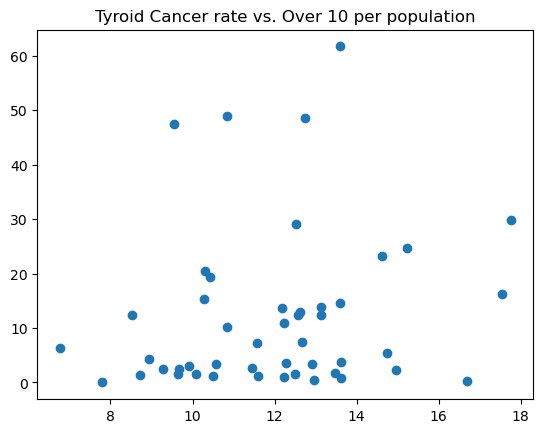

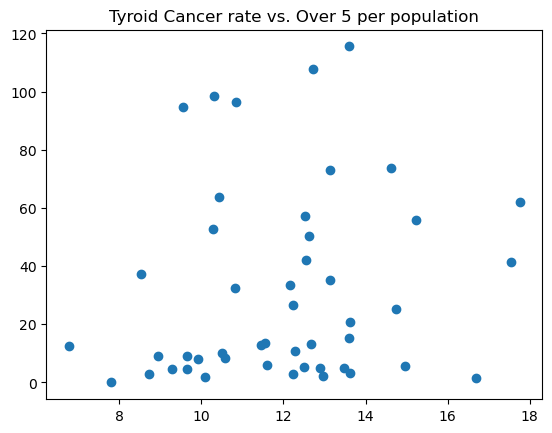

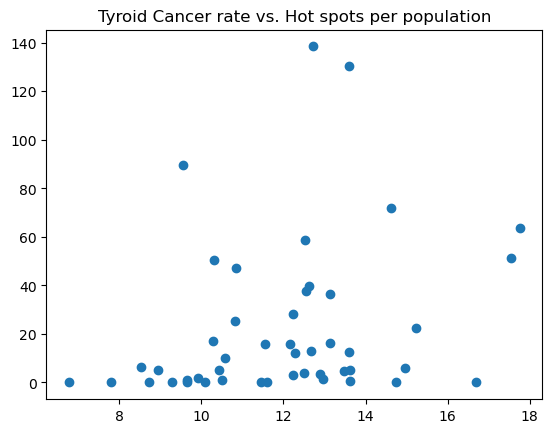

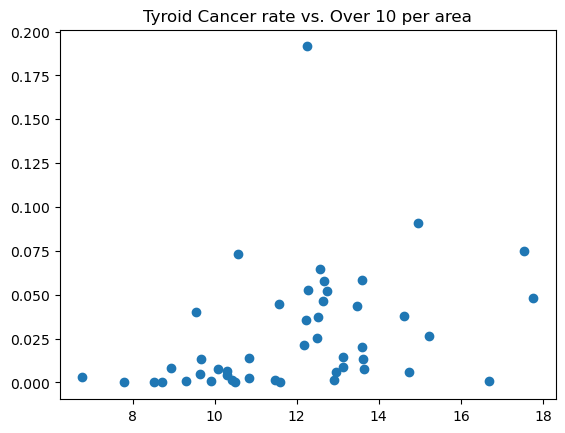

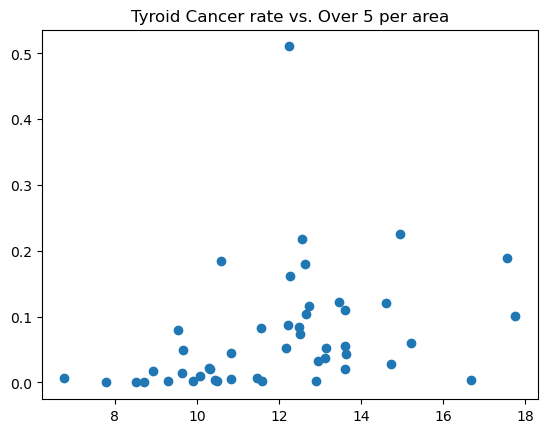

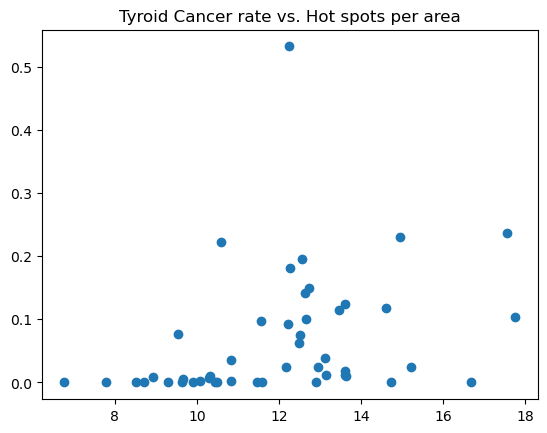

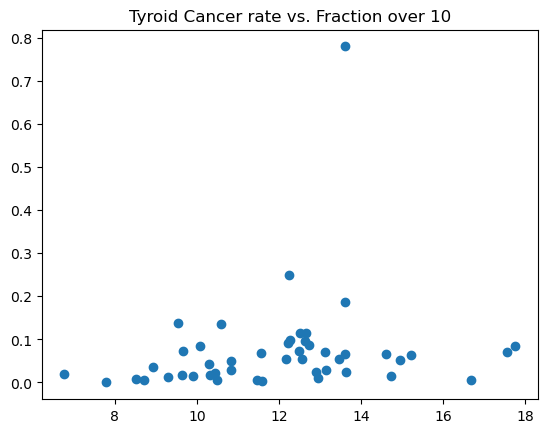

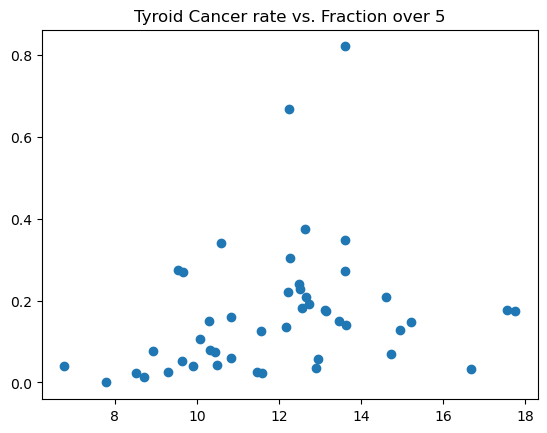

In [137]:
# Let's make some plots

# per population

plt.plot(tc_rate,over10/pop,'o')
plt.title('Tyroid Cancer rate vs. Over 10 per population')
plt.show()

plt.plot(tc_rate,over5/pop,'o')
plt.title('Tyroid Cancer rate vs. Over 5 per population')
plt.show()

plt.plot(tc_rate,hotspots/pop,'o')
plt.title('Tyroid Cancer rate vs. Hot spots per population')
plt.show()


# per area

plt.plot(tc_rate,over10/area,'o')
plt.title('Tyroid Cancer rate vs. Over 10 per area')
plt.show()

plt.plot(tc_rate,over5/area,'o')
plt.title('Tyroid Cancer rate vs. Over 5 per area')
plt.show()

plt.plot(tc_rate,hotspots/area,'o')
plt.title('Tyroid Cancer rate vs. Hot spots per area')
plt.show()


# fraction of contaminated wells


plt.plot(tc_rate,over10/wells,'o')
plt.title('Tyroid Cancer rate vs. Fraction over 10')
plt.show()

plt.plot(tc_rate,over5/wells,'o')
plt.title('Tyroid Cancer rate vs. Fraction over 5')
plt.show()


<h3>

Plotting the thyroid cancer rates vs. nitrate contamination (either per populaiton or per area or fraction of wells) all looks pretty bad.  Let's calculate the correlations and p-values.  We'll get 8 results:
    
</h3>

In [138]:
# calculate tyroid rates vs nitraes corrected for population

print('Corrected for population')

over10_pop = scipy_stats.pearsonr(tc_rate,over10/pop)
over5_pop = scipy_stats.pearsonr(tc_rate,over5/pop)
hotspots_pop = scipy_stats.pearsonr(tc_rate,hotspots/pop)

print('Over 10  ',over10_pop)
print('Over 5   ',over5_pop)
print('Hot Spots',hotspots_pop)

print(' ')

print('Corrected for area')

over10_area = scipy_stats.pearsonr(tc_rate,over10/area)
over5_area = scipy_stats.pearsonr(tc_rate,over5/area)
hotspots_area = scipy_stats.pearsonr(tc_rate,hotspots/area)

print('Over 10  ',over10_area)
print('Over 5   ',over5_area)
print('Hot Spots',hotspots_area)


print(' ')

print('Corrected for fraciont of wells')

over10_wells = scipy_stats.pearsonr(tc_rate,over10/wells)
over5_wells = scipy_stats.pearsonr(tc_rate,over5/wells)

print('Over 10  ',over10_wells)
print('Over 5   ',over5_wells)



Corrected for population
Over 10   PearsonRResult(statistic=0.16613374975290499, pvalue=0.26439486493657244)
Over 5    PearsonRResult(statistic=0.1583542173773182, pvalue=0.28773009242566416)
Hot Spots PearsonRResult(statistic=0.26763779618892475, pvalue=0.06894766422569959)
 
Corrected for area
Over 10   PearsonRResult(statistic=0.34495535297628227, pvalue=0.017567461554094648)
Over 5    PearsonRResult(statistic=0.3374736587010739, pvalue=0.020350758147942218)
Hot Spots PearsonRResult(statistic=0.32054028801899576, pvalue=0.028044614741489955)
 
Corrected for fraciont of wells
Over 10   PearsonRResult(statistic=0.1835322824330138, pvalue=0.21687730889703638)
Over 5    PearsonRResult(statistic=0.25923513741416815, pvalue=0.07847759596777973)


<h3>

Normalizing per populaton this results are not significant.  Normalizing per area, we get some okay pvalues, 0.01 to 0.03, but not super small.

Let's take a look at dooing rank instead.
    
</h3>

[10.58  9.29 10.83 10.31 12.49  9.91 14.74 14.61 12.9   8.52 12.73 15.23
  6.77 10.84 13.47 13.14 10.08  8.72 10.5  13.6  12.52  8.94  7.79 14.95
 16.69 12.23 12.96 10.29 13.13 12.67 12.24 12.56  9.54 13.62 17.76 12.28
 11.56 11.59 11.46 10.43  9.66  9.64 12.63 12.17 13.6  17.55 13.63]
[15.  5. 16. 12. 25.  9. 41. 40. 31.  2. 30. 43.  0. 17. 35. 34. 10.  3.
 14. 37. 26.  4.  1. 42. 44. 22. 32. 11. 33. 29. 23. 27.  6. 38. 46. 24.
 19. 20. 18. 13.  8.  7. 28. 21. 36. 45. 39.]
[12 22  9 17 21  1 32 41 40  5 16 27  3 39 18  0  2 13 38 36 37 43 25 30
 35  4 20 31 42 29 10  8 26 28 15 14 44 19 33 46  7  6 23 11 24 45 34]


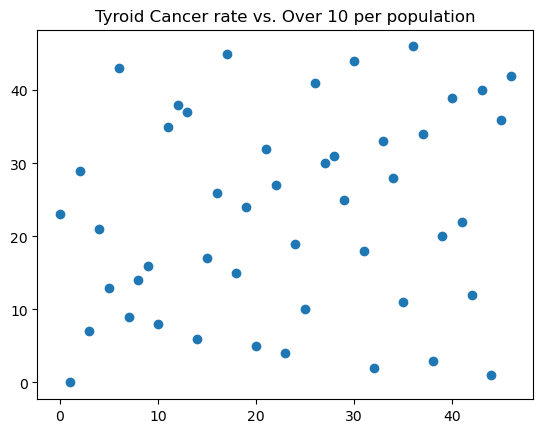

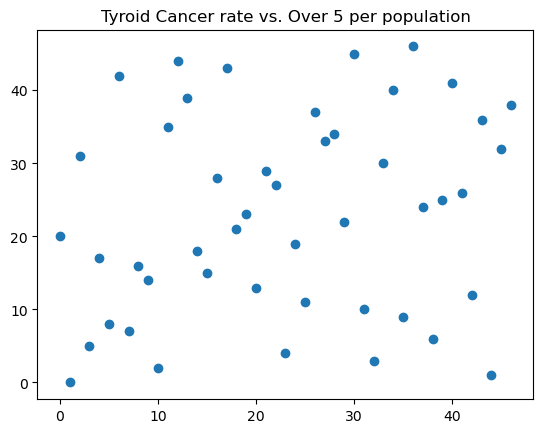

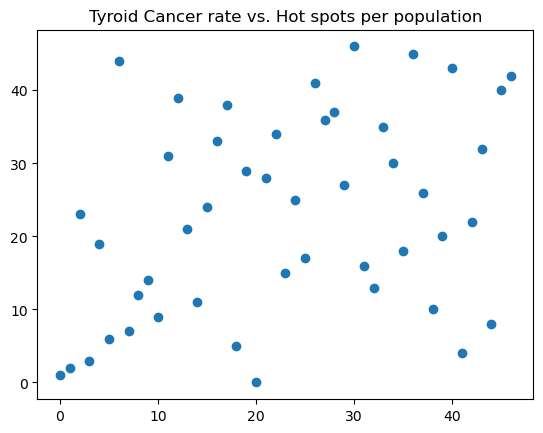

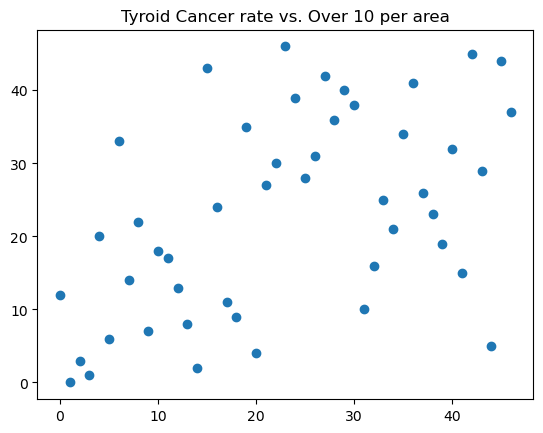

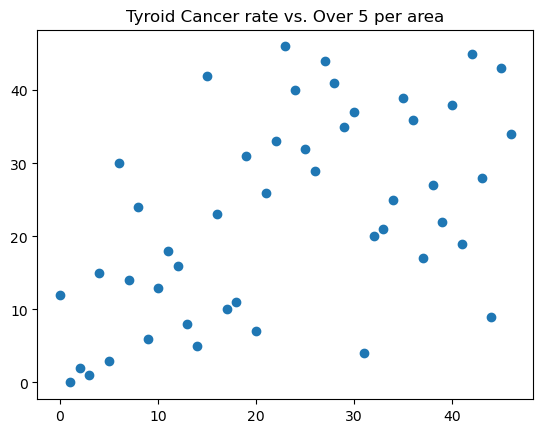

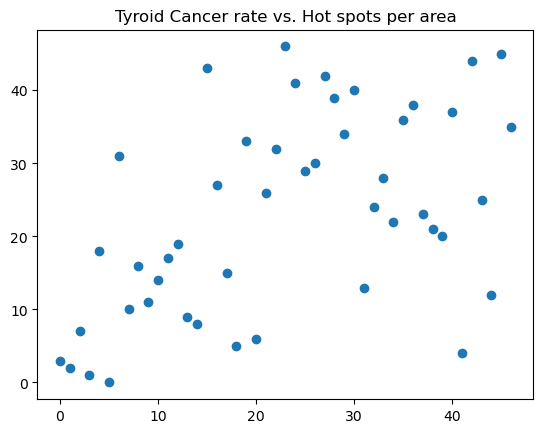

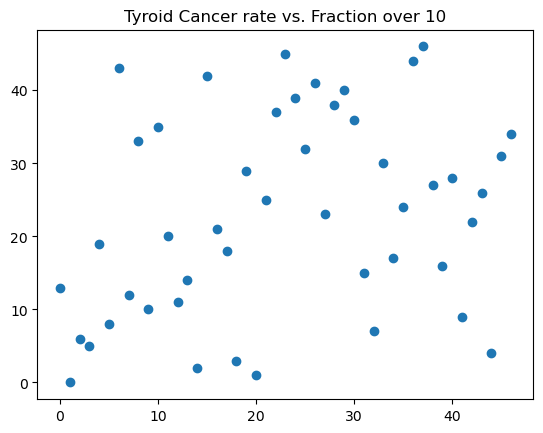

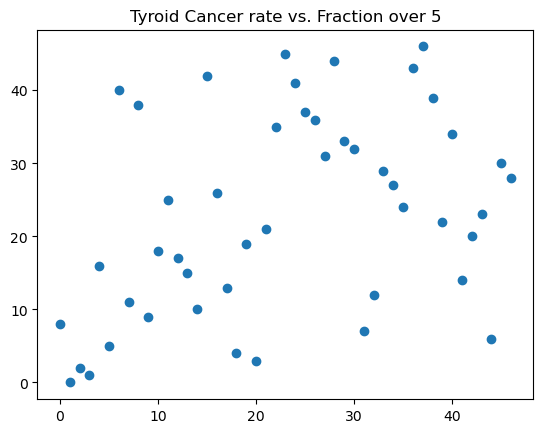

In [173]:
# Rank the different data sets.  Make sure to do the corrections first.

index = np.arange(tc_rate.size)

rank_tc_rate = np.argsort(tc_rate)
rate = np.zeros(tc_rate.size)
rate[rank_tc_rate] = index
r_tc_rate = np.copy(rate)

rank = np.argsort(over10/pop)
rate = np.zeros(tc_rate.size)
rate[rank] = index
r_over10_pop = np.copy(rate)

rank = np.argsort(over5/pop)
rate = np.zeros(tc_rate.size)
rate[rank] = index
r_over5_pop = np.copy(rate)


rank = np.argsort(hotspots/pop)
rate = np.zeros(tc_rate.size)
rate[rank] = index
r_hotspots_pop = np.copy(rate)



#r_over10_area = np.argsort(over10/area)
#r_over5_area = np.argsort(over5/area)
#r_hotspots_area = np.argsort(hotspots/area)

rank = np.argsort(over10/area)
rate = np.zeros(tc_rate.size)
rate[rank] = index
r_over10_area = np.copy(rate)

rank = np.argsort(over5/area)
rate = np.zeros(tc_rate.size)
rate[rank] = index
r_over5_area = np.copy(rate)

rank = np.argsort(hotspots/area)
rate = np.zeros(tc_rate.size)
rate[rank] = index
r_hotspots_area = np.copy(rate)



#r_over10_wells = np.argsort(over10/wells)
#r_over5_wells = np.argsort(over5/wells)

rank = np.argsort(over10/wells)
rate = np.zeros(tc_rate.size)
rate[rank] = index
r_over10_wells = np.copy(rate)

rank = np.argsort(over5/wells)
rate = np.zeros(tc_rate.size)
rate[rank] = index
r_over5_wells = np.copy(rate)


print(tc_rate)
print(r_tc_rate)
#print(r_tc_rate[index])
print(rank_tc_rate)



# per population

plt.plot(r_tc_rate,r_over10_pop,'o')
plt.title('Tyroid Cancer rate vs. Over 10 per population')
plt.show()

plt.plot(r_tc_rate,r_over5_pop,'o')
plt.title('Tyroid Cancer rate vs. Over 5 per population')
plt.show()

plt.plot(r_tc_rate,r_hotspots_pop,'o')
plt.title('Tyroid Cancer rate vs. Hot spots per population')
plt.show()


# per area

plt.plot(r_tc_rate,r_over10_area,'o')
plt.title('Tyroid Cancer rate vs. Over 10 per area')
plt.show()

plt.plot(r_tc_rate,r_over5_area,'o')
plt.title('Tyroid Cancer rate vs. Over 5 per area')
plt.show()

plt.plot(r_tc_rate,r_hotspots_area,'o')
plt.title('Tyroid Cancer rate vs. Hot spots per area')
plt.show()


# fraction of contaminated wells


plt.plot(r_tc_rate,r_over10_wells,'o')
plt.title('Tyroid Cancer rate vs. Fraction over 10')
plt.show()

plt.plot(r_tc_rate,r_over5_wells,'o')
plt.title('Tyroid Cancer rate vs. Fraction over 5')
plt.show()



<h3>

These all really look like scatter plots, but we can see a bit of correlation here.  We need to do some analysis to see if anything is significant.

Let's calculate our Speaman's rho correlations:
    
</h3>

In [180]:
# Calcualte Spearman's rho correlation for our 8 cobminations:

print('Spearman rho corrected for population')

rho_over10_pop = scipy_stats.spearmanr(tc_rate,over10/pop)
rho_over5_pop = scipy_stats.spearmanr(tc_rate,over5/pop)
rho_hotspots_pop = scipy_stats.spearmanr(tc_rate,hotspots/pop)

print('Over 10  ',rho_over10_pop)
print('Over 5   ',rho_over5_pop)
print('Hot Spots',rho_hotspots_pop)


print(' ')

print('Spearman rho corrected for area')

rho_over10_area = scipy_stats.spearmanr(tc_rate,over10/area)
rho_over5_area = scipy_stats.spearmanr(tc_rate,over5/area)
rho_hotspots_area = scipy_stats.spearmanr(tc_rate,hotspots/area)

print('Over 10  ',rho_over10_area)
print('Over 5   ',rho_over5_area)
print('Hot Spots',rho_hotspots_area)


print(' ')

print('Corrected for fraciont of wells')

rho_over10_wells = scipy_stats.spearmanr(tc_rate,over10/wells)
rho_over5_wells = scipy_stats.spearmanr(tc_rate,over5/wells)
rho_over5_wells = scipy_stats.spearmanr(r_tc_rate,r_over5_wells)

print('Over 10  ',rho_over10_wells)
print('Over 5   ',rho_over5_wells)




Spearman rho corrected for population
Over 10   SignificanceResult(statistic=0.1950796450758811, pvalue=0.18882876750341365)
Over 5    SignificanceResult(statistic=0.1949640080604242, pvalue=0.18909617243510832)
Hot Spots SignificanceResult(statistic=0.34567873575812824, pvalue=0.017316330085019725)
 
Spearman rho corrected for area
Over 10   SignificanceResult(statistic=0.49533115570986175, pvalue=0.00040024130282504327)
Over 5    SignificanceResult(statistic=0.5337226448415704, pvalue=0.00011184493284625621)
Hot Spots SignificanceResult(statistic=0.509107348978004, pvalue=0.0002577209273931317)
 
Corrected for fraciont of wells
Over 10   SignificanceResult(statistic=0.2988060479407687, pvalue=0.04132825692260428)
Over 5    SignificanceResult(statistic=0.3858695652173913, pvalue=0.0073892181551634415)


<h3>

It looks like corection the number of wells per population doesn't give you a great correlation.  Though the hotspots per population is marginally significant.  This makes some sense - the number of wells doesn't really tell you how many people are drinking from them, and you are not sampling every well.  Plus, nearby wells should have the same amount of contaminaton (roughly), so hotspots might be better data.

Looking at the number of contaminated wells per area, or hotspots per area, gives you a much stronger correlation.  These are very significant values.

The fraction of wells contminated is more a a mixed bag.  The fraction over 10 ppm gives a marginally significant result, but the fraction over 5 ppm has a much smaller p-value.  The number of wells over 5 ppm is about 2.5 times the number over 10 ppm, so we might just be getting less variance with more wells.
    
</h3>

 
Average number of wells over10, over5, total, per region
66.51063829787235
164.74468085106383
932.4893617021277
 
Stddev number of wells over10, over5, total, per region
97.89266209007668
228.21877037736778
1123.8337476869158
 
Average fraction of wells over10, over5, per region
0.07298494087115069
0.16742511575270208
 
Stddev average fraction of wells over10, over5, per region
0.11566044132546348
0.15614598880102956


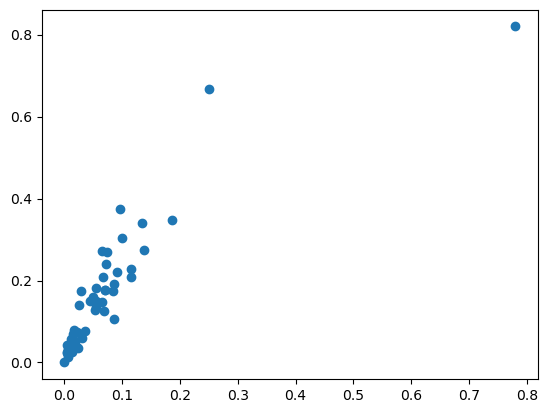

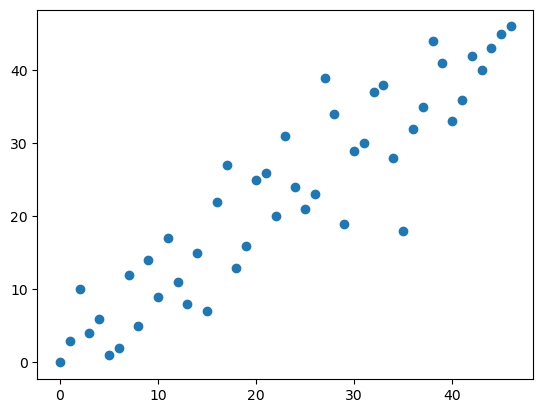

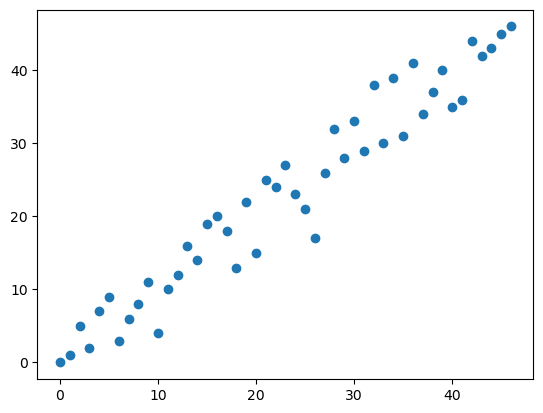

SignificanceResult(statistic=0.918709528214616, pvalue=8.946452646721824e-20)
SignificanceResult(statistic=0.9693570767807586, pvalue=4.472762351284891e-29)


In [195]:
# Here I'm playing around with a few different ways to see why the p-value is better for over5/wells vs. over10/wells.

print(' ')

print('Average number of wells over10, over5, total, per region')
print(np.mean(over10))
print(np.mean(over5))
print(np.mean(wells))

print(' ')

print('Stddev number of wells over10, over5, total, per region')
print(np.std(over10))
print(np.std(over5))
print(np.std(wells))

print(' ')

print('Average fraction of wells over10, over5, per region')
print(np.mean(over10/wells))
print(np.mean(over5/wells))

print(' ')

print('Stddev average fraction of wells over10, over5, per region')
print(np.std(over10/wells))
print(np.std(over5/wells))

plt.plot(over10/wells,over5/wells,'o')
plt.show()

plt.plot(r_over10_wells,r_over5_wells,'o')
plt.show()


plt.plot(r_over10_area,r_over5_area,'o')
plt.show()

print(scipy_stats.spearmanr(over10/wells,over5/wells))
print(scipy_stats.spearmanr(over10/area,over5/area))